In [159]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset 


In [160]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [161]:
# Declare constants
isUsedWholeDataSet = False
maxSubSet = 50000

In [162]:
# Define transformation for resizing and normalizing images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]) 

In [163]:
# Define a collate function to move each batch to GPU
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images).to(device)  # Stack images and move to GPU
    labels = torch.tensor(labels).to(device)  # Convert labels to tensor and move to GPU
    return images, labels


In [164]:
# Load the full dataset
dataset = datasets.ImageFolder(root="./img_align_celeba", transform=transform)

selectDataSet = dataset if isUsedWholeDataSet else Subset(
    dataset, range(maxSubSet))

# Create DataLoader with the custom collate function
batch_size = 512  # Adjust based on your GPU memory
dataloader = DataLoader(selectDataSet, batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

In [165]:
firstBatch = next(iter(dataloader))

(firstBatchImages,firstBatchLabel) = firstBatch

In [166]:
firstBatchImages[1].size()

torch.Size([3, 128, 128])

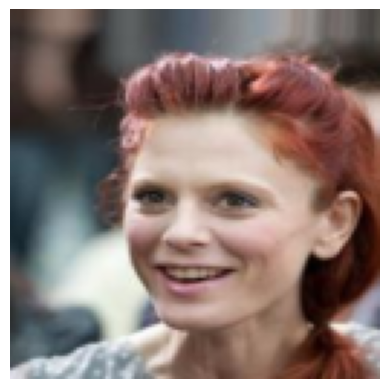

In [167]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the first image from the batch
image = firstBatchImages[1]

# Convert the tensor image to a format suitable for displaying
image = F.to_pil_image(image)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axes
plt.show()


In [168]:
import torch.nn as nn

# Define a simple model to compute the mean
class MeanFaceModel(nn.Module):
    def __init__(self):
        super(MeanFaceModel, self).__init__()
        self.mean_face = nn.Parameter(torch.zeros(3, 128, 128, dtype=torch.float32), requires_grad=False)
        self.num_images = 0

    def forward(self, images):
        # Accumulate sum and count
        batch_sum = images.sum(dim=0)  # Sum over the batch
        batch_size = images.size(0)
        return batch_sum, batch_size
    
model = MeanFaceModel().to(device)
model = nn.DataParallel(model)  # Enable multi-GPU support

In [169]:
# Get GPU properties
device_id = 0  # Use the first GPU (or change if using multiple GPUs)
device_properties = torch.cuda.get_device_properties(device_id)

# Calculate the number of CUDA cores
cuda_cores_per_sm = {
    "3.0": 192,  # Kepler
    "3.5": 192,
    "3.7": 192,
    "5.0": 128,  # Maxwell
    "5.2": 128,
    "5.3": 128,
    "6.0": 64,   # Pascal
    "6.1": 128,
    "6.2": 128,
    "7.0": 64,   # Volta
    "7.5": 64,   # Turing
    "8.0": 64,   # Ampere
    "8.6": 128,  # Ampere
    "8.9": 128   # Ada Lovelace
}
compute_capability = f"{device_properties.major}.{device_properties.minor}"
cores_per_sm = cuda_cores_per_sm.get(compute_capability, "Unknown")
total_cores = device_properties.multi_processor_count * cores_per_sm

# Display information
print(f"Device: {device_properties.name}")
print(f"Compute Capability: {compute_capability}")
print(f"Number of Streaming Multiprocessors: {device_properties.multi_processor_count}")
print(f"Total CUDA Cores: {total_cores}")


Device: NVIDIA GeForce RTX 4070 Laptop GPU
Compute Capability: 8.9
Number of Streaming Multiprocessors: 36
Total CUDA Cores: 4608


In [170]:

# Initialize a tensor to accumulate pixel values
total_sum = torch.zeros(3, 128, 128, device=device)
total_count = 0

for images, _ in dataloader:
    images = images.to(device, dtype=torch.float16)  # Move images to GPU in FP16
    batch_sum, batch_size = model(images)
    total_sum += batch_sum.to(torch.float32)  # Convert to FP32 for stability
    total_count += batch_size

# Compute the average (mean face) by dividing by the number of images
mean_face = total_sum / total_count

# Move the result back to CPU for visualization
mean_face_np = mean_face.permute(1, 2, 0).cpu().numpy()



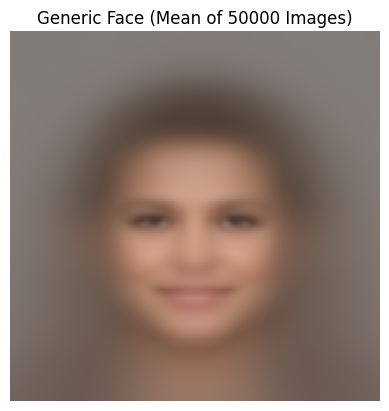

In [171]:
# Plot the "average" face
plt.imshow(mean_face_np)
plt.axis('off')
plt.title(f'Generic Face (Mean of {total_count} Images)')
plt.show()